# Topic Modeling on Amazon Phone and Accessories Reviews using NLP

## Introduction

Online shopping now makes our life much easier than it used to be.  Without the need of going out and visting a shopping mall or a grocery store, we can buy anything we want through e-shopping. 

But online shopping comes with its own caveats. One of the biggest challenges, and I guess almost every would face, is verifying the authenticity of a product. Is it as good as advertised on the e-commerce site? Will the product has a good quality? Are the reviews given by other customers really true or are they false advertising, or are they fake or bots' reviews? These are important questions customers need to ask before splurging their money.

## Importance of online reviews

I believe there are a bunch of people like me, who believe in customers' reviews much much more than the fancy product description of an item. In making our decision in buying a product, if most customers' reviews talking about how good it is, then it is probably a really good product. If every customer talks bad about a product, I am afraid I will not buy it no matter how good it shows me in the product description. And in some funny cases, which is quite often from my perspective, some users like to leave a high rating or score no matter how bad they think the product is. Oh god, this is tricky!

![rating screenshot](https://raw.githubusercontent.com/haochen23/Images/master/NLP%20product%20rating%20screenshot/phone_ratings%20snapshot.png)
      

## Identifying the problem

Here, an interesting problem comes up. What if the number of reviews is in the hundreds or thousands? It’s just not feasible to go through all those reviews, right? And this is where natural language processing (NLP) comes up trumps. But how?

Online reviews can be really overwhelming in terms of numbers and information, an intelligent system, capable of finding key insights (topics) from these reviews, will be of great help for the consumers to get an real impression on products.

__To solve this task, we will use the concept of Topic Modeling (LDA) on Amazon Phone and Accessories Review data. The dataset can be downloaded [here](http://jmcauley.ucsd.edu/data/amazon/).__ The details of the dataset will be given in the following section during exploratory analysis.

## Topic modeling

Topic Modeling is a process to automatically identify topics present in a text object and to derive hidden patterns exhibited by a text corpus. Topic Models are very useful for multiple purposes, including:

- Document clustering
- Organizing large blocks of textual data
- Text feature selection
- information retrieval from unstructured text

In the case of online product reviews, we intend to extract a certain number of groups of important words from the reviews. These groups of words are basically the topics which would help in ascertaining what the consumers are actually talking about in the reviews.

## Analyzing the review dataset

First, let's import the necessary libraries.

In [1]:
# import libraries
import nltk
from nltk import FreqDist

import numpy as np
import pandas as pd

import re
import spacy

import gensim
from gensim import corpora
import warnings
warnings.filterwarnings("ignore")
#libraries for visualization
import matplotlib.pyplot as plt
# plt.style.use('classic')
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
%matplotlib inline

C:\Users\hche958\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Loading data

The online review data is stored in a json file. Let's read in the file, and take a look at what's in the dataset.

In [2]:
# load the dataset
df = pd.read_json('data\\Cell_Phones_and_Accessories_5.json', lines = True)
print(df.shape)
df.head()

(194439, 9)


,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,120401325X,"[0, 0]",4,They look good and stick good! I just don't li...,"05 21, 2014",A30TL5EWN6DFXT,christina,Looks Good,1400630400
1,120401325X,"[0, 0]",5,These stickers work like the review says they ...,"01 14, 2014",ASY55RVNIL0UD,emily l.,Really great product.,1389657600
2,120401325X,"[0, 0]",5,These are awesome and make my phone look so st...,"06 26, 2014",A2TMXE2AFO7ONB,Erica,LOVE LOVE LOVE,1403740800
3,120401325X,"[4, 4]",4,Item arrived in great time and was in perfect ...,"10 21, 2013",AWJ0WZQYMYFQ4,JM,Cute!,1382313600
4,120401325X,"[2, 3]",5,"awesome! stays on, and looks great. can be use...","02 3, 2013",ATX7CZYFXI1KW,patrice m rogoza,leopard home button sticker for iphone 4s,1359849600


In the Phone and Accessories review dataset, we have nearly 200,000 total reviews and 9 columns. The columns contain the following information:

- __asin__ - product ID
- __helpful__ - helpfulness rating of the review, e.g. [19, 19] means 19 out of 19 people think this review is helpful
- __overall__ - rating of the product (1 - 5 stars)
- __reviewText__ - the text content of the review
- __reviewTime__ - tiem of the review (raw)
- __reviewerID__ - reviewer ID
- __reviewerName__ - reviewer name
- __summary__ - summary of the review
- __unixReviewTime__ - time of the review (unix time)

For the scope of our analysis and making it simple, we will be using only the __reviewText__ column.

### Data cleansing

Data cleansing is a important step before NLP analysis. The original text in the reviews data is very complicated. It contains many punctuations, stopwords and useful information etc. 

In this cleaning and preprocessing step, we should remove the punctuations, stopwords and normalize the reviews as much as possible. After every preprocessing step, it is a good practice to check the most frequent words in the data. Therefore, let’s define a function that would plot a bar graph of n most frequent words in the data.

In [3]:
# function to plot most frequent words
def freq_words(x, words = 30):
    
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    
    #frequency distribution
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word': list(fdist.keys()), 
                            'count': list(fdist.values())})
    # select the top 30 (default) most frequent words
    d = words_df.nlargest(columns = 'count', n = words)
    plt.figure(figsize = (20, 5))
    ax = sns.barplot(data = d, x = "word", y = "count")
    
    ax.set(ylabel = 'Count')
    plt.show()

Let's find out the most frequent words in the __reviewText__ column without any preprocessing.

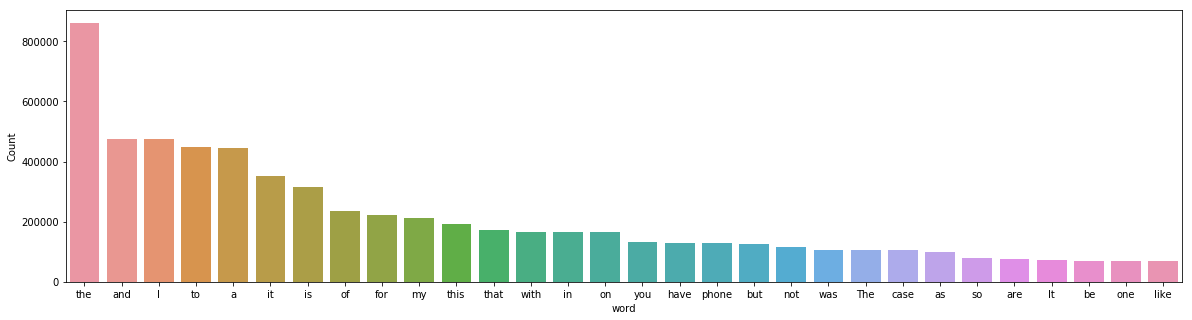

In [4]:
freq_words(df['reviewText'])

As can be easily find, the most common words without any preprocessing are 'the', 'and', 'to', 'a' etc. These words contain little information and are not so important for us to find the key topics. We have to remove these types of words. Before that we also need to remove the punctuations and numbers from the data.

In [5]:
# remove unwanted characters, numbers and symbols
df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")

In [6]:
# import stopwords library
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# function toremove stopwords and very short words (< 2 letters)
# from the review text
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words
df['reviewText'] = df['reviewText'].apply(lambda x: 
                     ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords
reviews = [remove_stopwords(r.split()) for r in df['reviewText']]

# lowercase the reviews
reviews = [r.lower() for r in reviews]

After removing the numbers, special characters and the stopwords, let's now look again at the 30 most frequent words.

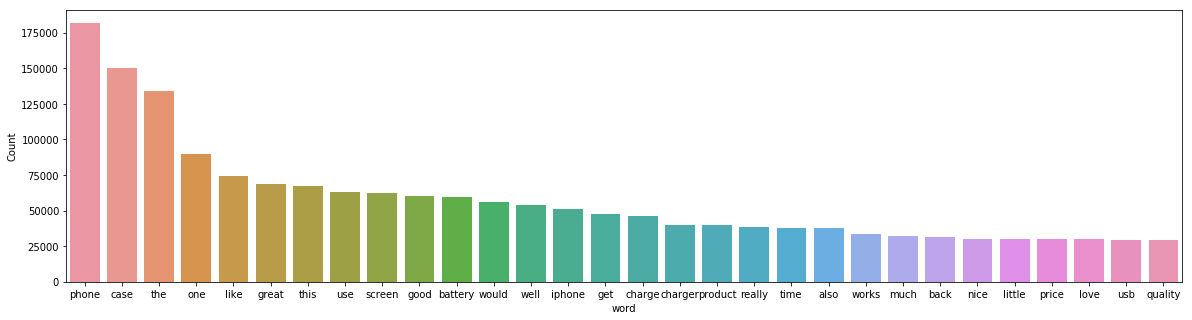

In [7]:
freq_words(reviews)

We observe some improvement in the result. We can find some more useful words in the chart, like "battery', 'price', 'good', 'product', 'oil' and so on. However,  some neutral terms such 'the', 'this', 'they' etc. still stay at the top positions. 

To further remove noise from the text we can use lemmatization from the spaCy library. It reduces any given word to its base form thereby reducing multiple forms of a word to a single word.

In [8]:
nlp = spacy.load('en', disable = ['parser', 'ner'])
# function to filter noun and adjective
def lemmatization(texts, tags = ['NOUN', 'ADJ']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        output.append([token.lemma_ for token in doc if
                      token.pos_ in tags])
    return output

### Tokenize and lemmatize the reviews

In [9]:
# tokenization
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())

# an example after tokenization
print(tokenized_reviews[2])

['these', 'awesome', 'make', 'phone', 'look', 'stylish', 'used', 'one', 'far', 'almost', 'year', 'can', 'you', 'believe', 'that', 'one', 'year', 'great', 'quality']


In [10]:
# lemmatization
reviews_2 = lemmatization(tokenized_reviews)
#the above result followed by lemmatization
print(reviews_2[2])

['awesome', 'phone', 'stylish', 'year', 'year', 'great', 'quality']


As we can see, we have not only lemmatized the words in the reivews but also filtered out nouns and adjectives. Let’s de-tokenize the lemmatized reviews and plot the most common words.

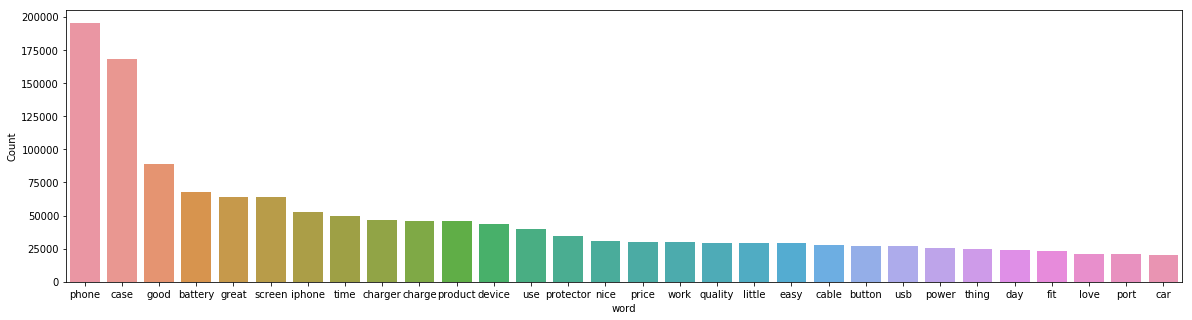

In [11]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))
    
df['reviews'] = reviews_3
freq_words(df['reviews'])

From the above chart of the top 30 words, we can see they all contain relevant information we are interested in. Now, let's move on and start building our topic model. Let's then visualize the frequent words using WordCloud.

A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

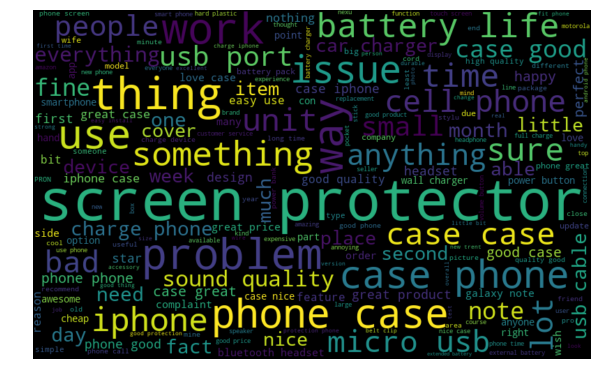

In [12]:
all_words = ' '.join([text for text in df['reviews']])

from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 500, random_state = 21, 
                     max_font_size = 110).generate(all_words)
plt.figure(figsize = (10,7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()



## Create the model

### Building the term dictionary of our corpus
Then we will convert the list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above.

In [13]:
dictionary = corpora.Dictionary(reviews_2)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

### Creating a Latent Dirichlet Allocation (LDA) model

We specify the model to find the num_topics = 5 topics.

In [14]:
# Creating the LDA model using gensim
LDA = gensim.models.ldamodel.LdaModel

lda_model = LDA(corpus = doc_term_matrix, id2word = dictionary, 
                num_topics = 5, random_state = 100, 
               chunksize = 1000, passes = 50)

Let's print out our 5 topics that the LDA model has learned.

In [15]:
lda_model.print_topics()

[(0,
  '0.056*"phone" + 0.014*"good" + 0.011*"app" + 0.010*"day" + 0.010*"time" + 0.009*"screen" + 0.008*"camera" + 0.008*"battery" + 0.007*"new" + 0.007*"great"'),
 (1,
  '0.095*"case" + 0.046*"phone" + 0.027*"screen" + 0.019*"good" + 0.018*"protector" + 0.016*"great" + 0.012*"protection" + 0.011*"color" + 0.010*"nice" + 0.010*"iphone"'),
 (2,
  '0.022*"phone" + 0.013*"use" + 0.010*"place" + 0.009*"car" + 0.009*"mount" + 0.009*"pad" + 0.009*"note" + 0.008*"tip" + 0.008*"small" + 0.008*"holder"'),
 (3,
  '0.037*"charger" + 0.036*"battery" + 0.036*"charge" + 0.030*"device" + 0.027*"cable" + 0.025*"usb" + 0.022*"power" + 0.021*"port" + 0.013*"phone" + 0.012*"time"'),
 (4,
  '0.039*"speaker" + 0.026*"bluetooth" + 0.024*"sound" + 0.023*"good" + 0.016*"quality" + 0.015*"headphone" + 0.015*"music" + 0.014*"button" + 0.013*"volume" + 0.012*"ear"')]

From the first topic, topic index number 0, we can see terms like "phone", "good", "app", "screen", "camera" and so on, indciating that the topic is very much related to hardware quality of cellphones. From the second topic, which is __Topic 1__, it might be raleted to accessories description of cellphones.

### Topics visulaization
To visualize our topics in a 2-dimensional space we will use the pyLDAvis library. This visualization is interactive in nature and displays topics along with the most relevant words.

In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.037501  0.204184       1        1  34.597252
3      0.070349 -0.187343       2        1  21.790972
0      0.123776  0.015018       3        1  20.136564
4      0.061790 -0.016005       4        1  14.371543
2     -0.293416 -0.015855       5        1   9.103677, topic_info=     Category           Freq        Term          Total  loglift  logprob
term                                                                     
54    Default  177660.000000        case  177660.000000  30.0000  30.0000
131   Default   43367.000000     charger   43367.000000  29.0000  29.0000
46    Default   42275.000000      charge   42275.000000  28.0000  28.0000
251   Default   30126.000000     speaker   30126.000000  27.0000  27.0000
52    Default   52259.000000     battery   52259.000000  26.0000  26.0000
218   Default   31916.000000       cable   31916.000000  25.0000  25.0000
228   Default   29768.000000         usb   29768.000000  24.0000  24.0000
248   Default   20281.000000   bluetooth   20281.000000  23.0000  23.0000
29    Default   59863.000000      screen   59863.000000  22.0000  22.0000
653   Default   18948.000000       sound   18948.000000  21.0000  21.0000
28    Default   32750.000000   protector   32750.000000  20.0000  20.0000
169   Default   28349.000000        port   28349.000000  19.0000  19.0000
68    Default   29420.000000       power   29420.000000  18.0000  18.0000
226   Default   51121.000000      device   51121.000000  17.0000  17.0000
8     Default  178956.000000       phone  178956.000000  16.0000  16.0000
1042  Default   11943.000000   headphone   11943.000000  15.0000  15.0000
350   Default   21676.000000  protection   21676.000000  14.0000  14.0000
1435  Default   12387.000000       music   12387.000000  13.0000  13.0000
347   Default   19671.000000       color   19671.000000  12.0000  12.0000
1009  Default   12758.000000      volume   12758.000000  11.0000  11.0000
1137  Default   12287.000000         app   12287.000000  10.0000  10.0000
1016  Default    9543.000000         ear    9543.000000   9.0000   9.0000
179   Default   16413.000000         car   16413.000000   8.0000   8.0000
249   Default    9002.000000     headset    9002.000000   7.0000   7.0000
17    Default   29462.000000     quality   29462.000000   6.0000   6.0000
20    Default   30439.000000      button   30439.000000   5.0000   5.0000
320   Default   16144.000000       cover   16144.000000   4.0000   4.0000
243   Default   11646.000000      tablet   11646.000000   3.0000   3.0000
223   Default   17220.000000     plastic   17220.000000   2.0000   2.0000
162   Default   13057.000000        unit   13057.000000   1.0000   1.0000
...       ...            ...         ...            ...      ...      ...
1760   Topic5     588.065796      summer     588.671753   2.3955  -6.7296
7424   Topic5     653.117920         fob     654.153381   2.3949  -6.6247
1392   Topic5    2036.862915    position    2157.233154   2.3391  -5.4873
1002   Topic5    1783.416626        band    2183.356934   2.1942  -5.6202
1643   Topic5    1490.403931        ring    1804.260986   2.2054  -5.7997
1455   Topic5    2376.200684       metal    3292.485352   2.0704  -5.3332
2049   Topic5    1866.770142        base    2518.125977   2.0972  -5.5745
424    Topic5    5166.082031       place    9936.607422   1.7424  -4.5566
665    Topic5    2348.182861       stand    3663.315918   1.9518  -5.3451
685    Topic5    2906.381104        clip    5214.238281   1.8120  -5.1318
839    Topic5    2590.916260        inch    4718.740234   1.7970  -5.2467
6      Topic5    1777.738037       stick    2715.283936   1.9729  -5.6234
179    Topic5    4519.198242         car   16413.300781   1.1067  -4.6904
158    Topic5    4303.280273        note   16137.526367   1.0747  -4.7393
240    Topic5    6262.219238         use   34584.609375   0.6876  -4.3642
691    Topic5    3235.97143

## Summary

From the above visualization, we can clearly see the most relevant of words in each topic learned by our model. By assigning a lager number to the _num_topics_ in our model training, we can find much more specific topics on the online reviews.

Topic modeling help us finding the most important topics in a large text review dataset. We can easily get an overview of all the reviews and find useful information for us to make purchasing desicions.